# Lecture 8. Introduction to multigrid

## Todays lecture
- The geometric multigrid
- The algebraic multigrid

## Model problem

As a a model problem, we will again consider the diffusion equation with variable coefficient.

$$\nabla \cdot k \nabla u = f, \quad u_{\partial \Omega} = 0,$$

$$\Omega = [0, 1]^ d.$$



## Poisson equation

And for illustration we will set $k = 1$, 

and solve the equation

$$-\Delta u = f, \quad u_{\partial \Omega} = 0, \quad \Omega=[0,1]^d.$$

In $1D$ we get $3$-point **stencil**, which is typically written as

$$A = \frac{1}{h^2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix}$$

Stencil notation is very convenient for **structured grids**. 

At each grid point we store $3$ numbers with indices $-1, 0, 1$, and the action of a linear operator is defined as

$$y = Ax, \rightarrow \quad y_j = \sum_{k=-1}^1 x_{j+k} A(j)_k,$$

and **out-of-bound** access is evaluated to $0$.




## 2D stencil

The notion of stencil is naturally extended to the 2D case, 

where  at each point we store a $3 \times 3$ matrix, and the whole matrix is stored as a

$$n \times n \times 3 \times 3$$ array.

The 2D Poisson in the stencil notation is written as

$$A = \frac{1}{h^2} \begin{bmatrix} 0 & -1 & 0 \\
-1 & 4 & -1\\
0 & -1 & 0
\end{bmatrix}.$$

In the same way we can write down non-constant coefficients.

## The history of multigrid

The idea of multigrid was proposed by R. Fedorenko http://mi.mathnet.ru/rus/zvmmf/v1/i5/p922	
"Релаксационный метод решения разностных эллиптических уравнений", 1961.

The theory was a little bit later provided by N. Bakhvalov. 

However, he gave the implementation to his PhD student and the PhD student failed, and Bakhvalov decided that the method "does not work". More than 5 year after, Brandt re-discovered multigrid in the West, and it worked. It became popular.

##  Model problem 

Consider a discretized 1D diffusion equation with zero boundary conditions

$$A_h u_h = f_h,$$ 

where
$$
A_h = \frac{1}{h^2} 
\begin{pmatrix}
2 & -1 \\
-1 & 2 & -1 \\
& -1 & \ddots & \ddots \\
& & \ddots & \ddots & -1 \\
& & & -1 & 2
\end{pmatrix}\quad \text{of size $N\times N$, $\ $ $ h = N^{-1}$}
$$
As we know $$\lambda_k(A_h) = \frac{4}{h^2} \sin^2 \frac{\pi kh}{2}>0, \quad \text{cond}(A_h) = \frac{\lambda_\max}{\lambda_\min} = \mathcal{O}\left(\frac{1}{h^2}\right)$$

## Iterative process
Consider Jacobi iterative process with relaxation parameter $\tau$ (fixed-point iteration with diagonal as a perconditioner):

$$
u^{(k+1)} = u^{(k)} - \tau \ D^{-1}(A_h u^{(k)} - f_h), \quad D = \text{diag}(A_h)\equiv \frac{2}{h^2} I. 
$$

## Convergence. Bad news
Let us show that the number of iterations required to get accuracy $\epsilon$ is $\mathcal{O}(N^2 \ln \epsilon)$.

For the error $e^{(k)} = u^{(k)} - u_h$ we have
$$
e^{(k+1)} = \left(I - \frac{\tau h^2}{2}A_h \right) e^{(k)}.
$$

It is known that (**show why**) the optimal tau is $\frac{\tau_{\text{opt}}h^2}{2} = \frac{2}{\lambda_{\min} + \lambda_{\max}}$.

Therefore,
$ \|e^{(k)}\|_2 \leqslant \left(\frac{1 - \lambda_\min/\lambda_\max}{1 + \lambda_\min/\lambda_\max}\right)^{k}\|e^{(0)}\|_2 = \left(\frac{1 - \mathcal{O}(N^{-2})}{1 + \mathcal{O}(N^{-2})}\right)^{k}\|e^{(0)}\|_2\leqslant \epsilon \quad \Longrightarrow$ <font color='red'>$\quad k = \mathcal{O}(N^2 \ln \epsilon)$</font>.

## Convergence example

The following example shows that even for $N = 20$ Jacobi method requires $1000$ iterations to reach $\epsilon=10^{-4}$

Text(0,0.5,'error')

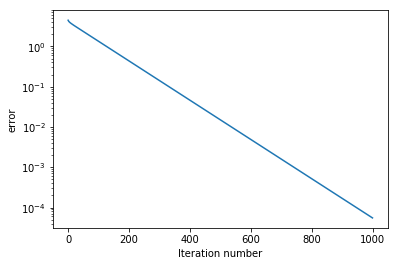

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix

n = 20
ex = np.ones(n);
lp1 = n**2*sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=2, which='LR')
ev2, vec = spla.eigs(lp1, k=2, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

niters = 1000
x = np.zeros(n)
res_all = []
for i in range(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    res_all.append(np.linalg.norm(rr))
    
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_all)
plt.xlabel('Iteration number')
plt.ylabel('error')

## Smoothing property. Good news 
Iterative processes remove high-frequency components in the error! Let us show that.

From the previous slide
$$
e^{(k+1)} = T e^{(k)} = T^{k} e^{(0)}, \quad \text{where}\quad T = \left(I - \frac{\tau h^2}{2}A_h \right).
$$

Let $$T \psi_i = \mu_i \psi_i,$$ 
where $\psi_i$ and $\mu_i$, $i=1,\dots,N$ are eigenvectors and eigenvalues of $T$.
Since $\{\psi_i\}$ is orthonormal basis (**explain why**), we have
$$e^{(0)} = \sum_{i=1}^N c_i \psi_i,$$
with some coefficients $c_i$. Therefore,
$$
e^{(k+1)} = T^{k} e^{(0)} = \sum_{i} c_i\lambda_i^k \psi_i
$$

Now the goal is to show that $\lambda_i^k$ decays fast enough with respect to $k$ when, for instance, $i>N/2$ (high-frequecy part of the spectrum). Indeed, 
$$
| \lambda_i(T)| = |1 - \frac{h^2}{4}\lambda_k(A_h)|<({\bf\text{show why}})<\frac{1}{2},\quad \text{when}\quad k>N/2 
$$
So, the high-frequency part of the error ($k>N/2$) becomes at least <font color='red'> 2 times smaller on each iteration </font>.m

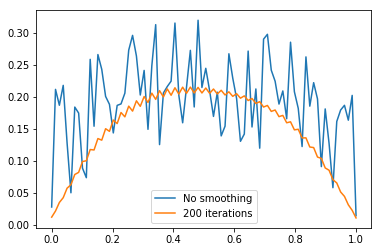

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix

n = 80
ex = np.ones(n);
lp1 = n**2 * sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=4, which='LR')
ev2, vec = spla.eigs(lp1, k=4, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = np.real(2.0/(lam_max + lam_min))

sol = spla.spsolve(lp1, rhs)
niters = 1000
x = 0.2*np.random.random(n) #random x0 to add high frequencies to the error
err_all = []
grid = np.linspace(0, 1, n)
for i in range(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    err = spla.spsolve(lp1, rr)
    err_all.append(err)
init, = plt.plot(grid, err_all[0])
smooth, = plt.plot(grid, err_all[200])
plt.legend([init, smooth], ['No smoothing', '200 iterations'])

#x = np.linspace(0, 1, n)
#def set_cursor(i):
#    plt.ylim(0, 1.1*np.max(err_all[0]))
#    plt.plot(x, err_all[i])
#    plt.xlabel('space')
#    plt.ylabel('error[i]')
#    plt.title('Error smoothing')
#from IPython.html.widgets import interact
#interact(set_cursor, i=(0, niters-1, 5))

## Geometric Multigrid

Now we know that in an iterative processes 
* High-frequecies ($k>N/2$) in error decay twice at each iteration 
* Low-frequencies in error decay really slow

But, we can approximate **smooth error vector on coarser grids**!

Equation on error: $A_h e_{h} = r_h $, where $r_h = f_h - A_h u$ is residual. Given $e_h$ we can simply get $u_h = e_h + u$

## A Two-Grid Cycle (almost multigrid :)) 

1. **Smoothing.** Do several iterations (say 2-3 Jacobi iterations) to reach $u$ with smooth $e_h = u - u_h$
2. **Restriction.** Restrict the residual $r_h = f_h - A u _h$ to the coarser grid $r_{2h} = Rr_h$
3. Solve $A_{2h} e_{2h} = r_{2h}$
4. **Prolongarion** (Interpolation). $e_h \approx P e_{2h}$
5. $u:= e_{h} + u$, then repeat from 1 if necesarry

Here 
* $R$ - restriction matrix
* $P$ - prolongation matrix

For the 1D case, N = 7:
$$
   P = 
 \frac{1}{2}
\begin{pmatrix}
1& \\
2& \\
1& 1& \\
 & 2& \\ 
 & 1& 1 \\
 &  & 2 \\ 
 &  & 1
\end{pmatrix},
\quad
R = \frac{1}{2} P^{T}
$$

## 2D case
In the 2D case, which is analogous, we can use **stencil notation** and **bilinear interpolation**:
$$
 P_{2D} = P\otimes P, \quad R_{2D} = R\otimes R\equiv \frac{1}{4}P_{2D}^{T}, 
$$
which corresponds to the following stencils

$$
\text{Restriction:}\quad
\begin{bmatrix}
  \frac{1}{16} & \frac{1}{8} & \frac{1}{16} \\
  \frac{1}{8} & \frac{1}{4} & \frac{1}{8} \\
  \frac{1}{16} & \frac{1}{8} & \frac{1}{16} 
\end{bmatrix}.
\quad
\text{Prolongation:} \quad
\begin{bmatrix}
  \frac{1}{4} & \frac{1}{2} & \frac{1}{4} \\
  \frac{1}{2} & 1 & \frac{1}{2} \\
  \frac{1}{4} & \frac{1}{2} & \frac{1}{4} 
\end{bmatrix}.
$$

$A_{2h}$ can be chosen either as an operator on a coarser grid (from differetial formulation) or as Galerkin projection $R A_h P$.

##  Finally... Multigrid

Multigrid need not stop at two grids! 

To find error on $2h$ we can go to $4h$ and so on. However, there are several different ways to go through grid levels.

<img width="700" src="pic/mg-cycle.jpg" />
[<a href="http://cvsp.cs.ntua.gr/research/gac/">source</a>]

1. **V-cycle**. Straightforward generalization of the two-grid cycle
2. **W-cycle**. On each coarse grid level V-cycle is called twice
3. **F-cycle** (full multigrid, FMG). Starts from the coarsest grid. Then prolongates to the next level to get a good initial approximation to run V-cycle

<!---
4. **S-cycle** (sawtooth cycle). No smoothing during restriction. Then starts from the coarsest grid and does prolongation procedures as it was in the V-cycle
-->

**W-cycle** is typically superior to a **V-cycle**. At the same time the **F-cycle** is asymptotically better than $V$ or $W$.

## Complexity of one cycle

Let $d$ be dimension of a problem. Then comutational cost of one cycle is
* V-cycle: $\mathcal{O} \left(N (1+2^{-d}+2^{-2d} + 2^{-3d} + \dots  )\right) = \mathcal{O} \left(\frac{N}{1 - 2^{-d}}\right)$
* F-cycle: $\mathcal{O} \left(\frac{N}{1 - 2^{-d}} (1+2^{-d}+2^{-2d} + 2^{-3d} + \dots  )\right) = \mathcal{O} \left(\frac{N}{(1 - 2^{-d})^2}\right)$

## Implementing things

What do you need to know to implement the multigrid?

First of all, you need to solve

$$A_h u_h = f_h.$$

You also need to have $P_h$, $R_h$, $A_{2h}$ - prolongation, restriction, coarse grid operator.

In a **geometric setting** you know the grids, you know coarse-grid discretization, you know prolongation/restriction operators (the latter is typically a bilinear operator).

## Reducing the implementation cost

First of all, if we know the restriction operator (from fine to coarse mesh),

we can select

$$P_h = R^{\top}_h.$$

Moreover, the coarse mesh operator can be written down as the **Galerkin projection**

$$A_{2h} = P_h A_h R_h = P_h A_h P^{\top}_h.$$

The only requirement is that the **sparsity pattern** of $A_{2h}$ does not grow.

## Selection the prolongation operator

Thus, the crucial choice is the choice of restriction operator.

Note, that if we use uniform grid in 2D and $3 \times 3$ stencil, using 

$3 \times 3$ stencil for the restriction operator gives for the Galerkin projection also the $3 \times 3$ stencil.


$$P= \frac{1}{4} \begin{bmatrix} 1 & 2 & 1 \end{bmatrix} \begin{bmatrix} 1 \\ 2 \\ 1 \end{bmatrix}. $$

However, this scheme stops to work if we have the problem

$$A u = \nabla \cdot k \nabla u = f,$$

with piecewise-constant $k$ with large jumps.

Another issue is the **convection-diffusion problems**, which lead to non-symmetric matrices.

## Solution: take coefficient-adaptive restriction operator!

Scheme: take the coefficient $k$, construct $P$.

One of the  efficient schemes was proposed by de Zeeuw,

[Matrix-dependent prolongations and restrictions in a blackbox multigrid solver](http://www.sciencedirect.com/science/article/pii/037704279090252U)

And it can be formulated as the representation of the prolongation operator in the Kronecker-product form

which in the stencil form can be written as

$$P \approx p q^{\top}.$$

## Note on the convergence

For a two-grid method, we have ($S$ is the smoother iteration).

$$u^{(new)}_h = S^{\nu_1} u_h + g_h,$$

$$r_h = g' - A_h S^{\nu_1} u_h, \quad, r_{2h} = g'' - R A_h S^{\nu_1} u_h, \quad e_{2h} = g''' - A^{-1}_{2h}  R A_h S^{\nu_1} u_h, $$

and

the new iteration
$$u^{(next)}_h = u_h + \widehat{g} - P A^{-1}_{2h} R A_h S^{\nu_1} u_h,$$

i.e. the iteration matrix has the form

$$M(\nu_1) =  I - P A^{-1}_{2h} R A_h S^{\nu_1}.$$

If this matrix has bounded norm, the whole process can be modified to get grid-independent convergence.

## Simple theory

Two properties are needed:

1. Approximation: $\Vert A^{-1}_h - P A^{-1}_{2h} R \Vert \leq C_A \Vert A^{-1}_h \Vert$
2. Smoothing property: $\Vert A_h S^{\nu} \Vert \leq \nu(v) \Vert A_h \Vert.$

 
 
 Then we have $\Vert M(\nu_1) \Vert \leq C.$
 
 The proof is trivial: $I - P A^{-1}_{2h} R A_h S^{\nu_1} = \left(A^{-1}_h - P A^{-1}_{2h} R \right) A_h S^{\nu_1}.$

## Algebraic Multigrid
What we have considered before is called geometric multigrid (GMG).

There is an alternative algebraic multigrid (AMG), where only sparse matrix is given (with no information concerning a grid structure). Then the grids and operators have to be constructed automatically.

## Why AMG?
- Difficult to build hierarchy of grid levels on unstructured grids (e.g. on irregular triangulation)
- Uniform coarsering with linear interpolation do not take into account operator structure. As a result, smoothers sometimes can not produce good approximation to be restricted on coarse grids. That is why geometric version may fail on
     - Poisson equation with discontinuous coefficients
     - Skewed operators
- Some problems are purely discrete with no geometric background
- AMG is black-box, so one does not need to know how to programm multigrid (AMG is more expensive than GMG though)

## Algebraic multigrid

The concept of geometric multigrid requires additional knowledge about the coarse spaces and the interpolation.

The concept of algebraic multigrid, first introduced by Ruge and Stuben in 1987, is to work only with the **sparsity pattern** in the spirit of sparse solvers.

The main question of AMG is how to construct **coarse meshes** and **interpolation operators**, since everything else is already there.

## Smoother for AMG

As a smoother we can use weighted Jacobi, Gauss-Seidel, Incomplete LU.

## Smoothing property (again)

The operator $S$ is a smoother, if

$$\Vert S v \Vert_A \leq \Vert v \Vert_A - \sigma \Vert v \Vert_2. $$

It means, it reduces the error when $\Vert v \Vert_2$ is relatively large with respect to $\Vert v \Vert_A$.

The error is called **algebraically smooth**, if $\Vert v \Vert_2 \ll \Vert v \Vert_A.$

A damped Jacobi method satisfied the smoothing property.

## Coarsening

Finally, we have to talk about coarsening. Given a graph of sparse matrix, we have to decide, which nodes will remain on the fine mesh, and which nodes will remain on the coarse mesh.

The nodes are called $F$-nodes and $C$-nodes.
 

## Strong coupling

A variable $i$ is said to be **strongly coupled** to the node $j$ if

$$|a_{ij}| \geq \varepsilon_{str} \max_{a_{ik} < 0} |a_{ik}|.$$


## Summary
- Geometric multigrid
- Algebraic multigrid